In [1]:
from aniso_custom_force import AnisoNeighborCustomForce
from flowermd.base import Simulation
import signac

/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/mbuild/recipes/__init__.py:13: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entry_points = metadata.entry_points()["mbuild.plugins"]


## Run ML Simulation

In [35]:
# force project
force_project = signac.get_project("/home/marjanalbooyeh/Aniso_ML_MD_project/Aniso_MLMD/aniso_MLMD/train_flow/force_pred_Mar11/")
best_force_job_id = "725a189391534aa475d9d4650b468b45"
best_force_job = force_project.open_job(id=best_force_job_id)

# torque project
torque_project = signac.get_project("/home/marjanalbooyeh/Aniso_ML_MD_project/Aniso_MLMD/aniso_MLMD/train_flow/torque_pred_Mar11/")
best_torque_job_id = "b13e69fe47e471ea38b35ccaa96e4852"
best_torque_job = torque_project.open_job(id=best_torque_job_id)

In [36]:
custom_force = AnisoNeighborCustomForce(best_force_job=best_force_job, best_torque_job=best_torque_job)

In [37]:
import gsd.hoomd
initial_rigid_snap = gsd.hoomd.open("/home/marjanalbooyeh/Aniso_ML_MD_project/Aniso_MLMD/aniso_MLMD/sampling/logs/pps_200/trajectory_3.0.gsd")[-1]

In [38]:
## convert the rigid snapshot to a cg snapshot (only taking out the rigid centers)
import numpy as np
import hoomd
rigid_ids = np.where(initial_rigid_snap.particles.typeid==0)[0]
N_beads = rigid_ids.shape[0]
cg_snapshpot = gsd.hoomd.Frame()
cg_snapshpot.particles.types = ["A"]
cg_snapshpot.particles.N = N_beads
cg_snapshpot.particles.typeid = [0] * N_beads

cg_snapshpot.particles.mass = initial_rigid_snap.particles.mass[:N_beads]
cg_snapshpot.particles.position = initial_rigid_snap.particles.position[:N_beads]
cg_snapshpot.particles.orientation = initial_rigid_snap.particles.orientation[:N_beads]
cg_snapshpot.particles.moment_inertia = initial_rigid_snap.particles.moment_inertia[:N_beads]
cg_snapshpot.particles.velocity = initial_rigid_snap.particles.velocity[:N_beads]

cg_snapshpot.configuration.box = initial_rigid_snap.configuration.box
with gsd.hoomd.open("cg_snapshot.gsd", "w") as traj:
    traj.append(cg_snapshpot)

In [39]:
sim = Simulation(cg_snapshpot, [custom_force], dt=0.0001,
                 gsd_write_freq=100,
                 gsd_file_name='ML_trajectory_kT_8.gsd',
                 log_write_freq=100,
                 log_file_name='ML_log_kT_8.txt',
                integrate_rotational_dof=True)

Initializing simulation state from a gsd.hoomd.Frame.


In [18]:
import cupy
with sim._state.gpu_local_snapshot as snap:
    rtags = cupy.array(snap.particles.rtag, copy=False)
    forces = cupy.array(snap.particles.net_force[rtags],
                                 copy=True)
    torques= cupy.array(snap.particles.net_torque[rtags],
                                 copy=True)


In [40]:
sim.run_NVT(n_steps=2e5, kT=8.0, tau_kt=0.1, write_at_start=True)

Step 100 of 200000; TPS: 94.52; ETA: 35.2 minutes
Step 200 of 200000; TPS: 112.12; ETA: 29.7 minutes
Step 300 of 200000; TPS: 119.75; ETA: 27.8 minutes
Step 400 of 200000; TPS: 124.01; ETA: 26.8 minutes
Step 500 of 200000; TPS: 126.8; ETA: 26.2 minutes
Step 600 of 200000; TPS: 128.11; ETA: 25.9 minutes
Step 700 of 200000; TPS: 129.6; ETA: 25.6 minutes
Step 800 of 200000; TPS: 130.7; ETA: 25.4 minutes
Step 900 of 200000; TPS: 131.49; ETA: 25.2 minutes
Step 1000 of 200000; TPS: 132.19; ETA: 25.1 minutes
Step 1100 of 200000; TPS: 132.73; ETA: 25.0 minutes
Step 1200 of 200000; TPS: 133.17; ETA: 24.9 minutes
Step 1300 of 200000; TPS: 133.59; ETA: 24.8 minutes
Step 1400 of 200000; TPS: 133.86; ETA: 24.7 minutes
Step 1500 of 200000; TPS: 134.14; ETA: 24.7 minutes
Step 1600 of 200000; TPS: 134.42; ETA: 24.6 minutes
Step 1700 of 200000; TPS: 134.67; ETA: 24.5 minutes
Step 1800 of 200000; TPS: 134.89; ETA: 24.5 minutes
Step 1900 of 200000; TPS: 135.13; ETA: 24.4 minutes
Step 2000 of 200000; TPS:

In [41]:
sim.flush_writers()

In [21]:
import cupy
with sim._state.gpu_local_snapshot as snap:
    rtags = cupy.array(snap.particles.rtag, copy=False)
    forces = cupy.array(snap.particles.net_force[rtags],
                                 copy=True)
    torques= cupy.array(snap.particles.net_torque[rtags],
                                 copy=True)


## AA Simulation 

In [42]:
from flowermd.library import PPS, OPLS_AA_PPS
from flowermd.base import Pack
pps = PPS(num_mols=N_beads, lengths=1)
system = Pack(molecules=pps, density=0.9, packing_expand_factor=7)
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True,
                        remove_charges=True, scale_charges=True,
                        remove_hydrogens=True)
pps_ff = system.hoomd_forcefield
system.pickle_forcefield("pps_ff.pkl")

/home/marjanalbooyeh/Aniso_ML_MD_project/Aniso_MLMD_March2024/flowerMD/flowermd/base/system.py:659: UserWarning: Units for density were not given, assuming units of g/cm**3.
  warnings.warn(
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/core/atom_type.py:198: UserWarning: Masses are assumed to be in units of g/mol
  warnings.warn(UNIT_WARNING_STRING.format("Masses", "g/mol"))
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/core/atom_type.py:209: UserWarning: Charges are assumed to be in units of elementary charge
  warnings.warn(
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/core/topology.py:871: UserWarning: An equivalent connection already exists. Providing the existing equivalent Connection.
  warnings.warn(
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/core/forcefield.py:533: UserWarning: ImproperType between atoms CA, CA, CA and HA is missing from the F

No charged group detected, skipping electrostatics.


/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:1247: UserWarning: RyckaertBellemansTorsionPotential will be converted to OPLSTorsionPotential.
  warnings.warn(
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:562: UserWarning: Orthorhombic box detected
  warnings.warn("Orthorhombic box detected")
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:117: NotYetImplementedWarning: Only writing particle, bond, sangle, proper and improper dihedral information.Special pairs are not currently written to GSD files
  warnings.warn(
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/external/convert_hoomd.py:274: UserWarning: Shifting coordinates to [-L/2, L/2]
  warnings.warn("Shifting coordinates to [-L/2, L/2]")
/home/marjanalbooyeh/miniconda3/envs/anisoML/lib/python3.11/site-packages/gmso/external/co

## Rigid body Simulation

In [43]:

aa_frame = gsd.hoomd.open("/home/marjanalbooyeh/Aniso_ML_MD_project/Aniso_MLMD/aniso_MLMD/sampling/assets/pps_aa_N200.gsd")[0]
positions = aa_frame.particles.position
# indices of constituent particles
constituent_indx = [np.arange(7) + (i*7) for i in range(N_beads) ]


com_mass = []
com_positions = []

for indx in constituent_indx:
    total_mass = np.sum(aa_frame.particles.mass[indx])
    com_mass.append(total_mass)
    com_positions.append(
                np.sum(
                    aa_frame.particles.position[indx]
                    * aa_frame.particles.mass[indx, np.newaxis],
                    axis=0,
                )
                / total_mass
            )


rel_const_pos =  positions[constituent_indx[0]] - com_positions[0]

In [44]:
def create_rigid_simulation(kT):
    rigid_simulation = hoomd.Simulation(device=hoomd.device.auto_select(), seed=1)
    rigid_simulation.create_state_from_snapshot(initial_rigid_snap)
    const_particle_types = list(np.asarray(aa_frame.particles.types)[list(aa_frame.particles.typeid)][constituent_indx[0]])

    rigid = hoomd.md.constrain.Rigid()
    rigid.body['rigid'] = {
        "constituent_types":const_particle_types,
        "positions": rel_const_pos,
        "orientations": [(1.0, 0.0, 0.0, 0.0)]* len(rel_const_pos),
        }
    integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
    rigid_simulation.operations.integrator = integrator
    integrator.rigid = rigid
    rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
    nvt = hoomd.md.methods.ConstantVolume(
        filter=rigid_centers_and_free,
        thermostat=hoomd.md.methods.thermostats.Bussi(kT=kT))
    integrator.methods.append(nvt)
    
    cell = hoomd.md.nlist.Cell(buffer=0, exclusions=['body'])
    
    lj = hoomd.md.pair.LJ(nlist=cell)
    
    # use aa pps simulation to define lj and special lj forces between constituent particles
    for k, v in dict(pps_ff[0].params).items():
        lj.params[k] = v
        lj.r_cut[k] = 2.5
    
    lj.params[('rigid', ['rigid', 'ca', 'sh'])]= dict(epsilon=0, sigma=0)
    lj.r_cut[('rigid', ['rigid', 'ca', 'sh'])] = 0

    integrator.forces.append(lj)
    rigid_simulation.state.thermalize_particle_momenta(filter=rigid_centers_and_free,
                                             kT=kT)
    
    rigid_simulation.run(0)

    
    log_quantities = [
                        "kinetic_temperature",
                        "potential_energy",
                        "kinetic_energy",
                        "volume",
                        "pressure",
                        "pressure_tensor",
                    ]
    logger = hoomd.logging.Logger(categories=["scalar", "string", "particle"])
    logger.add(rigid_simulation, quantities=["timestep", "tps"])
    thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
    rigid_simulation.operations.computes.append(thermo_props)
    logger.add(thermo_props, quantities=log_quantities)
    
    # for f in integrator.forces:
    #     logger.add(f, quantities=["energy", "forces", "energies"])

    logger.add(rigid_simulation.operations.integrator.rigid, quantities=["torques", "forces", "energies"])
    
    gsd_writer = hoomd.write.GSD(
        filename="rigid_trajectory_kT_8.gsd",
        trigger=hoomd.trigger.Periodic(int(100)),
        mode="wb",
        logger=logger,
        filter=hoomd.filter.All(),
        dynamic=["momentum", "property"]
        )
    
    rigid_simulation.operations.writers.append(gsd_writer)

    table_logger = hoomd.logging.Logger(categories=["scalar", "string"])
    table_logger.add(rigid_simulation, quantities=["timestep", "tps"])
    table_logger.add(thermo_props, quantities=log_quantities)
    table_file = hoomd.write.Table(
            output=open("rigid_log_kT_8.txt", mode="w", newline="\n"),
            trigger=hoomd.trigger.Periodic(int(100)),
            logger=table_logger,
            max_header_len=None,
        )
    rigid_simulation.operations.writers.append(table_file)
    return rigid_simulation

In [45]:
rigid_simulation = create_rigid_simulation(kT=8.0)

In [46]:
rigid_simulation.run(2e5, write_at_start=True)

In [47]:
rigid_simulation.operations.writers[0].flush()

In [15]:
rigid_simulation.state.get_snapshot().configuration.box

(9.551451683044434, 9.551451683044434, 9.551451683044434, 0.0, 0.0, 0.0)

## compare RDF

In [27]:
from cmeutils.structure import gsd_rdf

In [29]:
ML_rdf, ML_rdf_norm = gsd_rdf(gsdfile="ML_trajectory_kT_3.gsd", A_name="A", B_name="A",r_max=2.8, start=-100, stop=-1)
rigid_rdf, rigid_rdf_norm = gsd_rdf(gsdfile="rigid_trajectory_kT_3.gsd", A_name="rigid", B_name="rigid",r_max=2.8, start=-100, stop=-1)

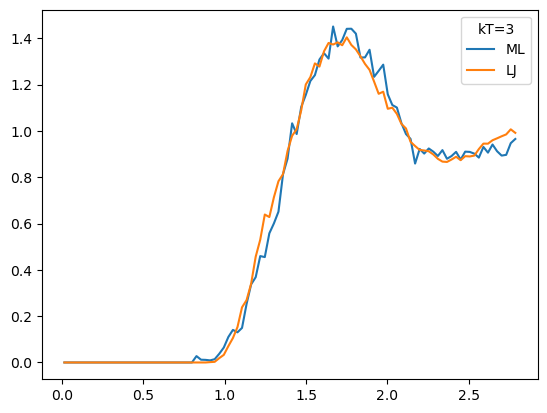

In [30]:
import matplotlib.pyplot as plt
plt.plot(ML_rdf.bin_centers, ML_rdf.rdf * ML_rdf_norm, label="ML")
plt.plot(rigid_rdf.bin_centers, rigid_rdf.rdf * rigid_rdf_norm, label="LJ")
plt.legend(title="kT=3")

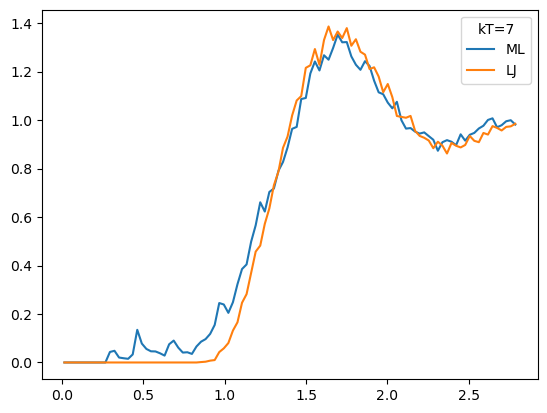

In [57]:
import matplotlib.pyplot as plt
plt.plot(ML_rdf.bin_centers, ML_rdf.rdf * ML_rdf_norm, label="ML")
plt.plot(rigid_rdf.bin_centers, rigid_rdf.rdf * rigid_rdf_norm, label="LJ")
plt.legend(title="kT=7")

In [16]:
from cmeutils.structure import gsd_rdf
ML_rdf, ML_rdf_norm = gsd_rdf(gsdfile="ML_trajectory_kT_0.5.gsd", A_name="A", B_name="A",r_max=2.8, start=-100, stop=-1)
rigid_rdf, rigid_rdf_norm = gsd_rdf(gsdfile="rigid_trajectory_kT_.gsd", A_name="rigid", B_name="rigid",r_max=2.8, start=-100, stop=-1)

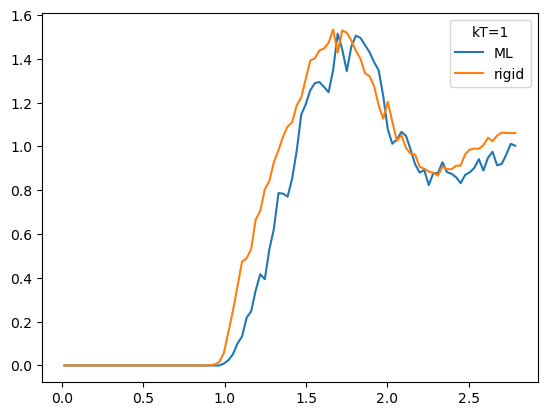

In [18]:
import matplotlib.pyplot as plt
plt.plot(ML_rdf.bin_centers, ML_rdf.rdf * ML_rdf_norm, label="ML")
plt.plot(rigid_rdf.bin_centers, rigid_rdf.rdf * rigid_rdf_norm, label="rigid")
plt.legend(title="kT=1")

In [16]:
from cmeutils.structure import gsd_rdf
ML_rdf, ML_rdf_norm = gsd_rdf(gsdfile="ML_trajectory_kT_0.5.gsd", A_name="A", B_name="A",r_max=2.8, start=-100, stop=-1)
rigid_rdf, rigid_rdf_norm = gsd_rdf(gsdfile="rigid_trajectory_kT_0.5.gsd", A_name="rigid", B_name="rigid",r_max=2.8, start=-100, stop=-1)

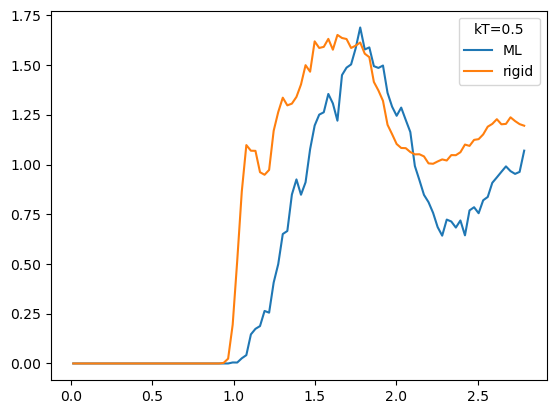

In [17]:
import matplotlib.pyplot as plt
plt.plot(ML_rdf.bin_centers, ML_rdf.rdf * ML_rdf_norm, label="ML")
plt.plot(rigid_rdf.bin_centers, rigid_rdf.rdf * rigid_rdf_norm, label="rigid")
plt.legend(title="kT=0.5")

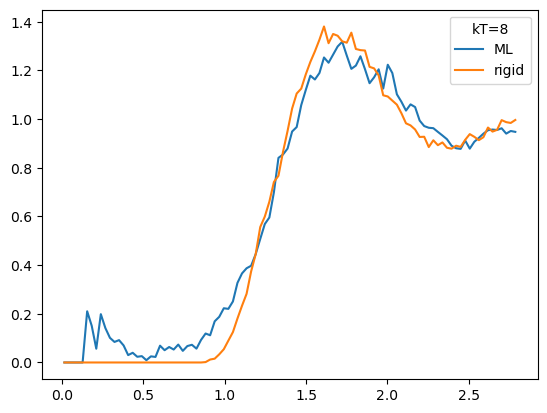

In [1]:
from cmeutils.structure import gsd_rdf
ML_rdf, ML_rdf_norm = gsd_rdf(gsdfile="ML_trajectory_kT_8.gsd", A_name="A", B_name="A",r_max=2.8, start=-1, stop=-1)
rigid_rdf, rigid_rdf_norm = gsd_rdf(gsdfile="rigid_trajectory_kT_8.gsd", A_name="rigid", B_name="rigid",r_max=2.8, start=-100, stop=-1)
import matplotlib.pyplot as plt
plt.plot(ML_rdf.bin_centers, ML_rdf.rdf * ML_rdf_norm, label="ML")
plt.plot(rigid_rdf.bin_centers, rigid_rdf.rdf * rigid_rdf_norm, label="rigid")
plt.legend(title="kT=8")

In [3]:
import gsd.hoomd
with gsd.hoomd.open("Ellipsoid_ML_kT_8.gsd", "w") as new_t:
    with gsd.hoomd.open("ML_trajectory_kT_8.gsd", "r") as old_t:
        for snap in old_t:
            snap.particles.type_shapes = [
                {"type": "Ellipsoid",
                    "a": 0.05,
                    "b": 0.39,
                    "c":0.635}
            ]
            snap.validate()
            new_t.append(snap)

In [3]:
with gsd.hoomd.open("Ellipse_ML_1.gsd", "w") as new_t:
    with gsd.hoomd.open("ML_trajectory_kT_1.gsd", "r") as old_t:
        for snap in old_t:
            snap.particles.type_shapes = [
                {"type": "Ellipsoid",
                    "a": 1.2,
                    "b": 0.5,
                    "c":0.5}
            ]
            snap.validate()
            new_t.append(snap)